In [1]:
import os
import sys

app_path = os.getcwd().rsplit(os.sep, 1)[0]

if app_path not in sys.path:
    sys.path.insert(0, app_path)

In [2]:
import pandas as pd

from utils.paths import raw_data_path
from utils.helpers import *

In [3]:
path = raw_data_path('train.csv')
df   = pd.read_csv(path)

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,5728806,Large private room in Nolita,4271676,Nat,Manhattan,Nolita,40.72217,-73.99481,Private room,120,7,3,2015-09-01,0.06,3,0
1,2243769,Super Bowl New York City Apartment,11460768,Brian,Manhattan,Upper West Side,40.80020,-73.96045,Entire home/apt,1500,1,0,NaN,NaN,1,0
2,35515415,COZY APT CLOSE TO LGA & JFK AND TRANSPORTATION,267193767,Jenny,Queens,East Elmhurst,40.75558,-73.89316,Entire home/apt,200,2,4,2019-07-05,4.00,1,365
3,36202006,Stream-Pressed Paradise (Laundry Room Setup),43392243,Rita,Staten Island,Concord,40.60110,-74.07830,Shared room,30,2,0,NaN,NaN,4,82
4,3780951,Charming Harlem apartment,16065171,Gina,Manhattan,Harlem,40.81022,-73.94266,Shared room,115,1,16,2019-05-26,0.27,1,365


## Imputing missing Last Review value with 1st Jan 2001

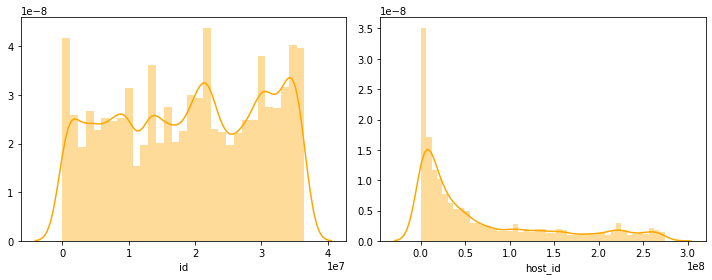

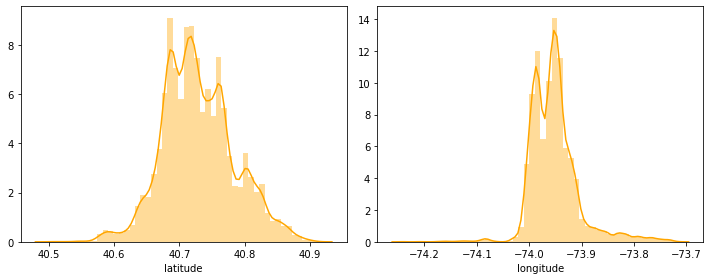

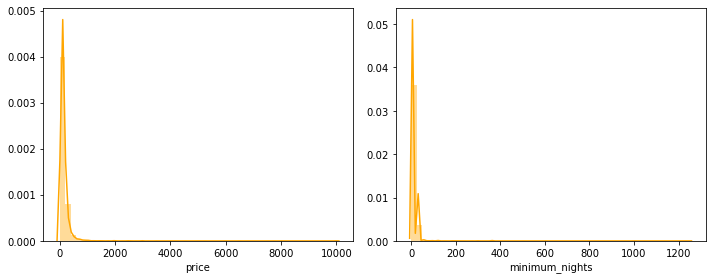

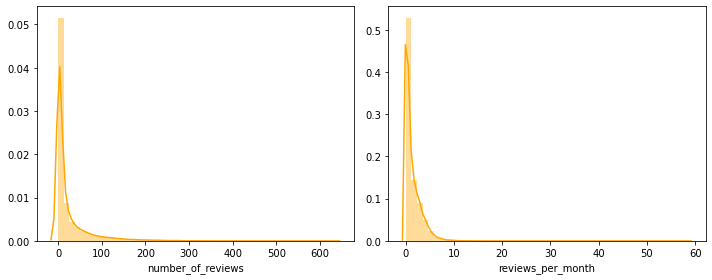

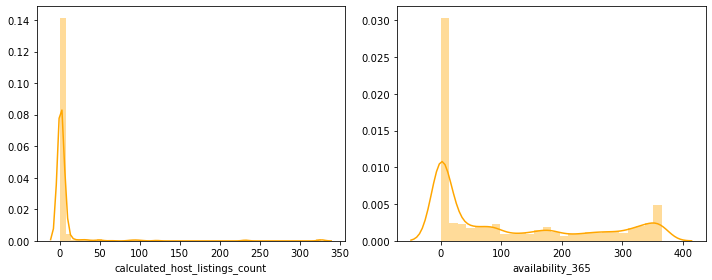

In [4]:
plot_distributions(df)

In [5]:
missing_values_percent(df)

id                                 0.000000
name                               0.035061
host_id                            0.000000
host_name                          0.037983
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.399696
reviews_per_month                 20.399696
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

In [9]:
bar_plot_categorical_columns(df.room_type)

AttributeError: 'Series' object has no attribute 'select_dtypes'

## END